In [1]:
import pandas as pd
import numpy as np
from src.utils_analysis import plot_all_result,calculate_log_returns

from src.optimization.tcn import create_sequence_data, scale_and_split_data, build_tcn_sharpe_ratio_model, train_model


In [2]:

# Load selected tickers from file
with open("data/selected_cluster_stocks.txt", "r") as f:
    tickers = [line.strip() for line in f]

# Define the file path template
test_file_path_template = "data/processed_data/test/{}_processed.csv"

# Load preprocessed data into a dictionary
test_data_dict = {}
for ticker in tickers:
    # Load each ticker's data and assume it has 'Normed Return' and other necessary columns
    test_data_dict[ticker] = pd.read_csv(test_file_path_template.format(ticker), index_col='date', parse_dates=True)

# Define the file path template
train_file_path_template = "data/processed_data/train/{}_processed.csv"

# Load preprocessed data into a dictionary
train_data_dict = {}
for ticker in tickers:
    # Load each ticker's data and assume it has 'Adj Close' or 'Normed Return' for log return calculation
    train_data_dict[ticker] = pd.read_csv(train_file_path_template.format(ticker), index_col='date', parse_dates=True)

# Set the starting amount for the portfolio
start_amount = 10000
num_tickers = len(tickers)

# Calculate log returns for all tickers
log_returns = calculate_log_returns(train_data_dict)


closing_prices = pd.DataFrame({ticker: train_data_dict[ticker]['adj_close'] for ticker in tickers}).dropna()
daily_returns = pd.DataFrame({ticker: train_data_dict[ticker]['Returns'] for ticker in tickers}).dropna()

In [3]:

x,y = create_sequence_data(daily_returns,look_back_window=100)

In [4]:
x_train, x_val, y_train, y_val = scale_and_split_data(x,y,test_size=0.1)

In [5]:
# Define model parameters
look_back_window = x_train.shape[1]
n_features = x_train.shape[2]
n_assets = y_train.shape[1]

# Build the model
model = build_tcn_sharpe_ratio_model(look_back_window, n_features, n_assets)


In [9]:

# Train the model
history = train_model(model, x_train, y_train, x_val, y_val)

Epoch 1/50
34/34 [==============================] - 5s 153ms/step - loss: 0.0143 - val_loss: 0.0021 - lr: 1.2500e-05
Epoch 2/50
34/34 [==============================] - 5s 151ms/step - loss: 0.0138 - val_loss: 0.0029 - lr: 1.2500e-05
Epoch 3/50
34/34 [==============================] - 5s 148ms/step - loss: 0.0157 - val_loss: 0.0063 - lr: 1.2500e-05
Epoch 4/50
34/34 [==============================] - 5s 150ms/step - loss: 0.0149 - val_loss: 0.0069 - lr: 1.2500e-05
Epoch 5/50
34/34 [==============================] - 5s 149ms/step - loss: 0.0153 - val_loss: 0.0068 - lr: 1.2500e-05
Epoch 6/50
34/34 [==============================] - 5s 149ms/step - loss: 0.0150 - val_loss: 0.0070 - lr: 1.2500e-05
Epoch 7/50
34/34 [==============================] - 5s 150ms/step - loss: 0.0160 - val_loss: 0.0070 - lr: 6.2500e-06
Epoch 8/50
34/34 [==============================] - 5s 148ms/step - loss: 0.0149 - val_loss: 0.0070 - lr: 6.2500e-06
Epoch 9/50
34/34 [==============================] - 5s 148ms/ste

INFO:tensorflow:Assets written to: models/tcn/tcn\assets


In [7]:
y_pred = model.predict(x_val)

3/3 [==============================] - 1s 39ms/step


In [14]:
weights = y_pred[-1]
allocation_TCN= {ticker: float(weight) for ticker, weight in zip(tickers, weights)}
import json
with open('data/weights/TCN.json', 'w') as f:
    json.dump(allocation_TCN, f)

Cumulative Portfolio Return: 38.57%
Daily Sharpe Ratio: 0.1181
Annualized Sharpe Ratio: 1.8742
Mean of Total Daily Return: 0.1369%
Standard Deviation of Total Daily Return: 1.1259%


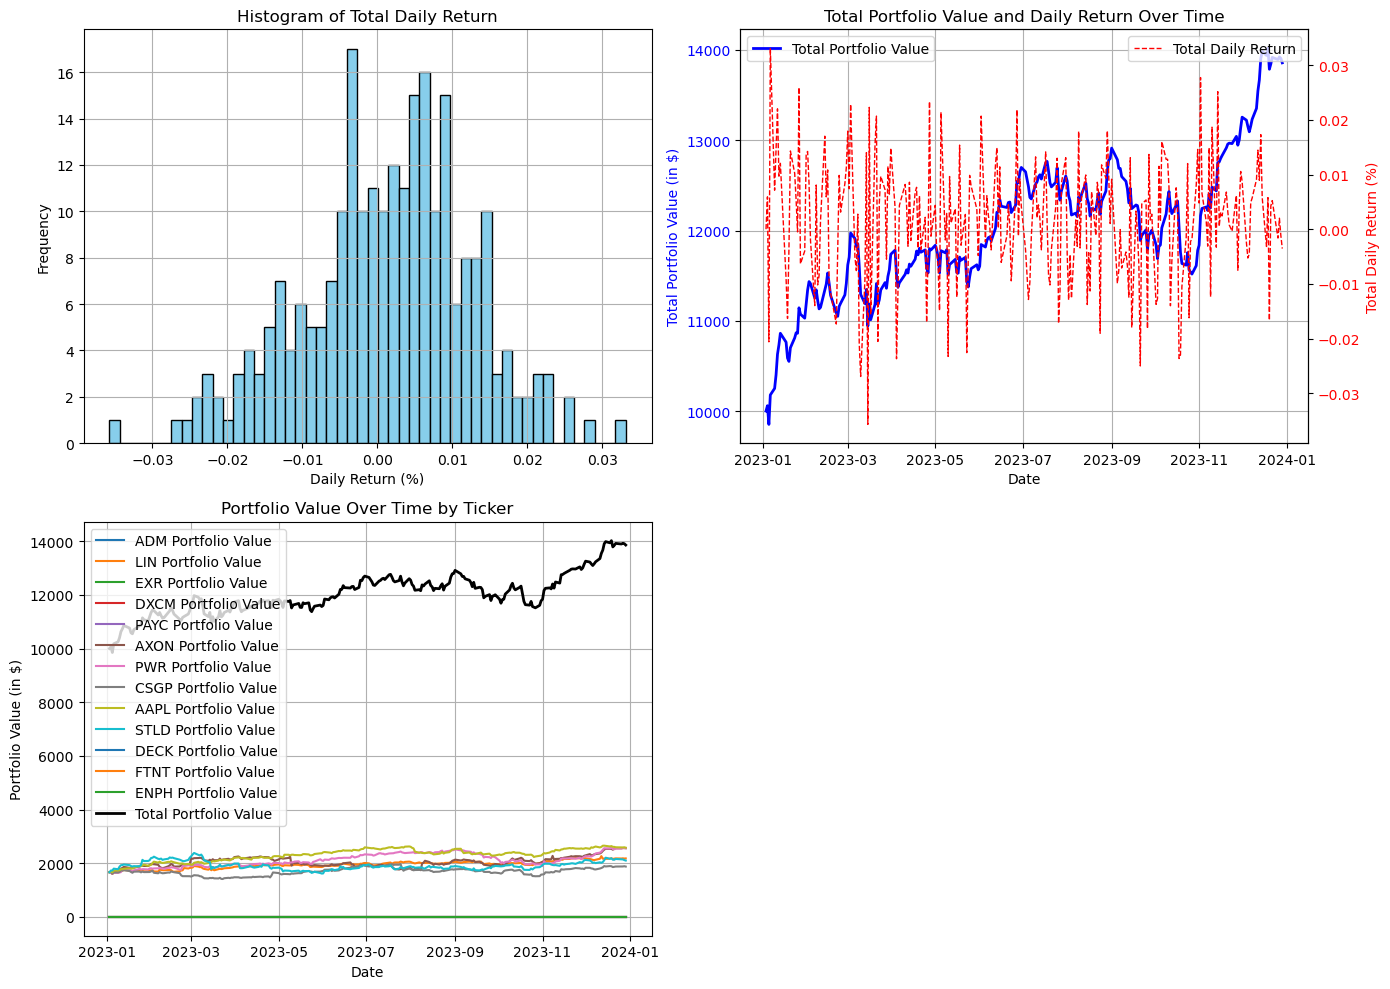

In [15]:
plot_all_result(allocation_TCN,test_data_dict)